# *Proyecto Quien es Quien (Profeco)* 💰
## (MCD ITAM Primavera 2024)

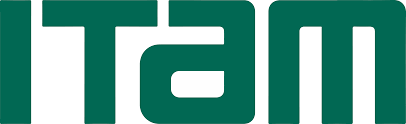

## *Autores* 📚

| Nombre                     |  CU    | Correo Electrónico | Usuario Github |
|----------------------------|--------|--------------------|----------------|
| Blanca E. García Manjarrez | 118886 | bgarci11@itam.mx   |    BGARCIAMA   |
| Iván García                | ###### | xxxxxxxx@itam.mx   |   xxxxxxxxxxx  |
| Valeria Durán              | ###### | xxxxxxxx@itam.mx   |   xxxxxxxxxxx  |
| Yuneri Pérez Arellano      | 199813 | yperezar@itam.mx   |    YunPerez    |

In [2]:
"""

Este notebook permite al usuario levantar 
un cluster en AWS con Hadoop y Pyspark 
A partir de ahi el usuario cuenta con un 
ETL que debe correrse en el Cluster para: 
 - Subir a S3 el archivo o archivos.
 - Cargar el CSV separado por pipes con la 
 información de los años 2018 a 2024 en Spark.
 - Guardar el CSV como parquet en S3 y particionar
 por `catalogo` y `año`.
 - Cargar el parquet en Spark para responder
 las preguntas.

Este notebook utiliza principalmente `pyspark`
para responder las preguntas.

"""

'\n\nEste notebook permite al usuario levantar \nun cluster en AWS con Hadoop y Pyspark \nA partir de ahi el usuario cuenta con un \nETL que debe correrse en el Cluster para: \n - Subir a S3 el archivo o archivos.\n - Cargar el CSV separado por pipes con la \n información de los años 2018 a 2024 en Spark.\n - Guardar el CSV como parquet en S3 y particionar\n por `catalogo` y `año`.\n - Cargar el parquet en Spark para responder\n las preguntas.\n\nEste notebook utiliza principalmente `pyspark`\npara responder las preguntas.\n\n'

In [1]:
# Librerías necesarias
from datetime import datetime, date
import pandas as pd
import matplotlib.pyplot as plt
import ipywidgets as widgets
from IPython.display import display

from pyspark.sql import SparkSession, Row
from pyspark.sql.functions import (
    col, max, count, countDistinct, first, regexp_replace, lower, coalesce,
    year, month, to_date, lit, row_number, min, trim
)
from pyspark.sql.types import IntegerType, DateType, StructType, StringType, LongType, DoubleType, StructField
from pyspark.sql.window import Window
from pyspark.storagelevel import StorageLevel
import pyspark.sql.functions as f

In [2]:
# Se inicializa una sesión de spark
spark = SparkSession.builder \
    .config("spark.executor.memory", "12g") \
    .config("spark.driver.memory", "8g") \
    .getOrCreate()

The operation couldn’t be completed. Unable to locate a Java Runtime.
Please visit http://www.java.com for information on installing Java.

/opt/homebrew/Caskroom/miniconda/base/envs/profeco_env/lib/python3.11/site-packages/pyspark/bin/spark-class: line 97: CMD: bad array subscript
head: illegal line count -- -1


PySparkRuntimeError: [JAVA_GATEWAY_EXITED] Java gateway process exited before sending its port number.

In [3]:
# Se lee el archivo .csv con la información de todos los años
df_profeco = spark.read \
    .option("header", "true") \
    .option("delimiter", "|") \
    .csv("data/QQP_total.csv")

#### *Verificamos qué información trae el dataset, con una muestra de 5 registros*

In [4]:
df_profeco.show(5, truncate=False)

+----+------------------+----------------------------------------------------+--------------+---------------------+-----------------+-------+-------------+---------------+---------------------------+--------------------------+---------------------------------------------------------------+--------------+--------------+---------+-----------+
|anio|producto          |presentacion                                        |marca         |categoria            |catalogo         |precio |fecharegistro|cadenacomercial|giro                       |nombrecomercial           |direccion                                                      |estado        |municipio     |latitud  |longitud   |
+----+------------------+----------------------------------------------------+--------------+---------------------+-----------------+-------+-------------+---------------+---------------------------+--------------------------+---------------------------------------------------------------+--------------+---------

#### *Declaramos cada variable con el tipo correcto para optimizar el almamacenamiento de la inforamción.*

In [5]:
# Declaramos el esquema de la tabla
schema = StructType([
    StructField("anio", IntegerType(), nullable=False),
    StructField("producto", StringType(), nullable=True),
    StructField("presentacion", StringType(), nullable=True),
    StructField("marca", StringType(), nullable=True),
    StructField("categoria", StringType(), nullable=True),
    StructField("catalogo", StringType(), nullable=True),
    StructField("precio", DoubleType(), nullable=True),
    StructField("fecharegistro", DateType(), nullable=True),
    StructField("cadenacomercial", StringType(), nullable=True),
    StructField("giro", StringType(), nullable=True),
    StructField("nombrecomercial", StringType(), nullable=True),
    StructField("direccion", StringType(), nullable=True),
    StructField("estado", StringType(), nullable=True),
    StructField("municipio", StringType(), nullable=True),
    StructField("latitud", DoubleType(), nullable=True),
    StructField("longitud", DoubleType(), nullable=True)
])

df_profeco = df_profeco.select([df_profeco[col].cast(schema[col].dataType) for col in df_profeco.columns])

In [6]:
df_profeco.printSchema()

root
 |-- anio: integer (nullable = true)
 |-- producto: string (nullable = true)
 |-- presentacion: string (nullable = true)
 |-- marca: string (nullable = true)
 |-- categoria: string (nullable = true)
 |-- catalogo: string (nullable = true)
 |-- precio: double (nullable = true)
 |-- fecharegistro: date (nullable = true)
 |-- cadenacomercial: string (nullable = true)
 |-- giro: string (nullable = true)
 |-- nombrecomercial: string (nullable = true)
 |-- direccion: string (nullable = true)
 |-- estado: string (nullable = true)
 |-- municipio: string (nullable = true)
 |-- latitud: double (nullable = true)
 |-- longitud: double (nullable = true)



#### *Verificamos cuantos registros unicos se tienen por cada variable*

In [7]:
# Conteos de registros unicos por variables
conteos = df_profeco.agg(*(countDistinct(col).alias(col + '_c') for col in df_profeco.columns))
conteos.show()

+------+----------+--------------+-------+-----------+----------+--------+---------------+-----------------+------+-----------------+-----------+--------+-----------+---------+----------+
|anio_c|producto_c|presentacion_c|marca_c|categoria_c|catalogo_c|precio_c|fecharegistro_c|cadenacomercial_c|giro_c|nombrecomercial_c|direccion_c|estado_c|municipio_c|latitud_c|longitud_c|
+------+----------+--------------+-------+-----------+----------+--------+---------------+-----------------+------+-----------------+-----------+--------+-----------+---------+----------+
|     7|       823|          8527|   1971|         42|        12|  143965|           1595|              415|    18|             3349|       3635|      32|         94|     3296|      3295|
+------+----------+--------------+-------+-----------+----------+--------+---------------+-----------------+------+-----------------+-----------+--------+-----------+---------+----------+



#### *Al revisar la información notamos que existen caracteres que pueden complicar el análisis por lo que los eliminamos y adecuamos.*

In [8]:
# Se reemplazan caracteres especiales
df_profeco = df_profeco.withColumn("catalogo", regexp_replace(trim("catalogo"), " ", "_")) \
                       .withColumn("estado", regexp_replace(trim("estado"), " ", "_")) \
                       .withColumn("marca", regexp_replace(regexp_replace(regexp_replace(trim("marca"), "\.", ""), "/", ""), "-", ""))

In [9]:
# Se reemplazan caracteres especiales en marca
df_profeco = df_profeco.withColumn("marca", regexp_replace("marca", " ", "_"))

#### *Guardamos la base de datos en parquets, particionando por catalogo y año, para posteriormente elegir unicamente el catalogo asignado al equipo.*

In [10]:
# Se guarda la información particionada en parquets
(df_profeco
     .write.parquet(
         "profecodb", 
         mode="overwrite", 
         partitionBy=["catalogo","anio"]
     )
)

# **Parte A**

# Contesta las siguientes preguntas utilizando PySpark. Realiza el siguiente análisis **(por año)** y sobre todos los catálogos.

# ¿Cuántos catálogos diferentes tenemos?

In [11]:
# Se cuentan los catálogos diferentes por año
num_catalogos_anio = (
    df_profeco
    .groupBy(lit(1).alias("Grupo"))
    .pivot("anio")
    .agg(countDistinct("catalogo"))
)

num_catalogos_anio.drop("Grupo").show()

+----+----+----+----+----+----+----+
|2018|2019|2020|2021|2022|2023|2024|
+----+----+----+----+----+----+----+
|  10|  11|  10|  10|  11|  11|  10|
+----+----+----+----+----+----+----+



#### *Se tienen entre 10 y 11 catálogos diferentes desde el 2018 hasta el 2024.*

# ¿Cuáles son los 20 catálogos con más observaciones? Guarda la salida de este query en tu bucket de S3, lo necesitaremos más adelante.

In [12]:
# Se muestran los catálogos con más observaciones por año
aux_catalogos_obs_anio = (
    df_profeco
    .groupBy("catalogo")
    .pivot("anio")
    .agg(count("catalogo").alias("Observaciones"))
)

total_obs = sum(col(str(year)) for year in range(2018, 2025))
top20_catalogos_obs_anio = (
    aux_catalogos_obs_anio
    .withColumn("Obs_Totales", total_obs)
    .orderBy("Obs_Totales", ascending=False)
    .limit(20)
)

top20_catalogos_obs_anio.show(20)

+-------------------+-------+-------+-------+-------+-------+-------+-------+-----------+
|           catalogo|   2018|   2019|   2020|   2021|   2022|   2023|   2024|Obs_Totales|
+-------------------+-------+-------+-------+-------+-------+-------+-------+-----------+
|            basicos|8804761|7398860|6170515|6919490|7945110|7742108|1986577|   46967421|
|       medicamentos|3657969|2887105|2571915|2937404|3177815|3192617| 798628|   19223453|
|  electrodomesticos|1735336|1352068| 602860|1004833|1029302|1183304| 267835|    7175538|
| frutas_y_legumbres| 938616| 702747| 643820| 756850| 926031| 861829| 211839|    5041732|
|   utiles_escolares| 665135| 575317| 219573| 549740| 421178| 442965|  62102|    2936010|
|           mercados| 457497| 381183| 312800| 318280| 367637| 324401|  76886|    2238684|
|           juguetes| 370421| 267730| 181907| 207318| 180332| 205361|  19114|    1432183|
|pescados_y_mariscos|  90040|  69658|  50978|  74902| 114753| 123335|  45966|     569632|
|         

#### *Derivado de que el análisis comprende el periodo de 2018 al 2024, unicamente se observó un máximo de 12 catálogos, siendo "basicos" el catálogo con más observaciones, seguido de "medicamentos", "electrodomesticos", etc.*

# ¿Tenemos datos de todos los estados del país? De no ser así, ¿cuáles faltan?

In [13]:
# Se extraen los estados observados por año en la base
edos_obs_anio = (
    df_profeco
    .groupBy("estado", "anio")
    .agg(count("estado").alias("Conteo"))
    .orderBy("Conteo", ascending=False)
)
# Se declaran los estados de méxico
edos_mexico = [
    "aguascalientes", "baja_california", "baja_california_sur", "campeche",
    "chiapas", "chihuahua", "ciudad_de_mexico", "coahuila_de_zaragoza",
    "colima", "durango", "estado_de_mexico", "guanajuato", "guerrero",
    "hidalgo", "jalisco", "michoacan_de_ocampo", "morelos", "nayarit",
    "nuevo_leon", "oaxaca", "puebla", "queretaro", "quintana_roo",
    "san_luis_potosi", "sinaloa", "sonora", "tabasco", "tamaulipas",
    "tlaxcala", "veracruz", "yucatan", "zacatecas"
]

years = list(range(2018, 2025))
# Crear el DataFrame de combinaciones estado-año
edos_anios = [(estado, year) for estado in edos_mexico for year in years]
edos_anios_df = spark.createDataFrame(edos_anios, ["estado", "anio"])

# Se obtienen los estados con datos faltantes
edos_faltantes = (
    edos_anios_df
    .join(edos_obs_anio, on=["estado", "anio"], how="left_anti")
    .groupBy("estado")
    .pivot("anio")
    .agg(lit(1))
)
# Se muestran los estados faltantes y se indica en que año falta
edos_faltantes.show()

+-------+----+----+----+----+
| estado|2021|2022|2023|2024|
+-------+----+----+----+----+
| colima|   1|   1|   1|   1|
|nayarit|   1|   1|   1|   1|
+-------+----+----+----+----+



#### *No. Los estados con datos faltantes por año, fueron Colima y Nayarit, ya que no tuvieron registros en desde el 2021 al 2024.*

# ¿Cuántas observaciones tenemos por estado?

In [14]:
# Se obtiene las obsercaciones por estado por año
obs_edos_anio = (
    df_profeco
    .groupBy("estado")
    .pivot("anio")
    .agg(count("*").alias("Conteo"))
    .orderBy("estado")
)

obs_edos_anio.show(32)

+--------------------+-------+-------+-------+-------+-------+-------+------+
|              estado|   2018|   2019|   2020|   2021|   2022|   2023|  2024|
+--------------------+-------+-------+-------+-------+-------+-------+------+
|      aguascalientes| 235847| 289973| 216598| 240772| 291820| 313809| 79726|
|     baja_california| 619093| 165344| 195002| 104216| 160203| 209715| 60414|
| baja_california_sur| 163771| 135558| 244874| 283821| 282548| 291569| 74986|
|            campeche| 270889| 273786| 253009| 289282| 298464| 303525| 76119|
|             chiapas| 360125| 236768| 124094| 164396| 164801|  88692| 24856|
|           chihuahua| 401630| 264343|   7797| 182849| 385359| 442131|114369|
|    ciudad_de_mexico|2492481|2495784|2446252|3062808|3355847|3320792|794834|
|coahuila_de_zaragoza| 345559| 271376| 226226| 228360| 232422| 246396| 66180|
|              colima| 262907| 283025|  14588|   NULL|   NULL|   NULL|  NULL|
|             durango| 287888| 270862| 238719| 247466| 247858| 2

#### *En la tabla anterior, se muestran las observaciones que cada estado tiene en la base de datos por año.*

# De cada estado obten: el número de catalogos diferentes por año, ¿ha aumentado el número de catálogos con el tiempo?

In [15]:
# Se obtiene el número de catálogos diferentes por año
catalogos_edo_anio = (
    df_profeco
    .groupBy("estado", "anio")
    .agg(countDistinct("catalogo").alias("num_catalogos"))
)

catalogos_edo_anio = (
    catalogos_edo_anio
    .groupBy("estado")
    .pivot("anio")
    .agg(first("num_catalogos"))
    .orderBy("estado")
)

catalogos_edo_anio.show(32)

+--------------------+----+----+----+----+----+----+----+
|              estado|2018|2019|2020|2021|2022|2023|2024|
+--------------------+----+----+----+----+----+----+----+
|      aguascalientes|   9|  11|   9|  10|  11|  11|   9|
|     baja_california|  10|  10|   9|   9|  11|  11|  10|
| baja_california_sur|   9|  10|   9|  10|  11|  11|  10|
|            campeche|   9|   9|   9|  10|  11|  11|   9|
|             chiapas|  10|  10|   9|   9|  10|  10|   8|
|           chihuahua|  10|  11|   5|  10|  11|  11|  10|
|    ciudad_de_mexico|  10|  10|   9|  10|  11|  11|  10|
|coahuila_de_zaragoza|  10|   9|   9|  10|  11|  11|  10|
|              colima|  10|  10|   4|NULL|NULL|NULL|NULL|
|             durango|  10|  10|   9|  10|  11|  11|   9|
|    estado_de_mexico|  10|  10|   9|  10|  11|  11|  10|
|          guanajuato|  10|  10|   9|  10|  11|  11|   9|
|            guerrero|  10|  10|   8|   8|   8|   7|   9|
|             hidalgo|  10|  11|   9|   9|  10|  11|   8|
|             

#### *Con los resultados anteriores, se puede observar que los catálogos no aumentan con el tiempo, ya que lo que se observa por estado es que disminuya, aumente o se mantenga durante los 7 años analizados (2018 a 2024).*



# Utilizando Spark contesta las siguientes preguntas a partir del catálogo que le tocó a tu equipo. Recuerda trabajar en el archivo con los datos particionados de otra manera tus queries van a tardar mucho.

In [16]:
# Se declara el path de donde se leerán los parquets
path_data = "profecodb/"
df_profecoBasicos = spark.read.parquet(f"{path_data}/catalogo=basicos")

## **Preprocesamiento**

#### *Se revisa la lectura del parquet sobre el catalogo "basicos" y se procede a homologar la variable "marca" unificando los nombres a partir de un catalogo creado para este fin.*

In [17]:
# Se carga un catalogo de marcas unicas
catalogo_df = spark.read.csv("marca/marcas_basicos.csv", header=True, inferSchema=True)

# Se homologan las marcas dejando marcas unicas
df_profecoBasicos = (df_profecoBasicos
    .withColumn("norm_marca", lower(regexp_replace("marca", "[\- ]", "")))
    .join(catalogo_df, col("norm_marca") == catalogo_df.marca, "left")
    .withColumnRenamed("marca_distinct", "new_norm_marca")
    .withColumn("norm_marca", coalesce(col("new_norm_marca"), col("norm_marca")))
    .drop("new_norm_marca", "marca")
    .withColumnRenamed("norm_marca", "marca")
)

df_profecoBasicos.show(5)

+--------------------+--------------------+---------+------+-------------+---------------+--------------------+--------------------+--------------------+----------------+---------+---------+----------+----+-----+
|            producto|        presentacion|categoria|precio|fecharegistro|cadenacomercial|                giro|     nombrecomercial|           direccion|          estado|municipio|  latitud|  longitud|anio|marca|
+--------------------+--------------------+---------+------+-------------+---------------+--------------------+--------------------+--------------------+----------------+---------+---------+----------+----+-----+
|pastelillos y pan...|paquete 255 gr. p...|      pan|  32.5|   2020-04-14|       chedraui|supermercado / ti...|chedraui sucursal...|alfredo del mazo ...|estado_de_mexico|   toluca|19.310981|-99.634817|2020|bimbo|
|pastelillos y pan...|paquete 255 gr. p...|      pan|  32.5|   2020-04-14|       chedraui|supermercado / ti...|chedraui sucursal...|alfredo del mazo

# ¿Cuańtas marcas diferentes tiene tu categoría?

In [18]:
# Se obtienen cuantas marcas diferentes hay en Basicos
df_profecoBasicos.agg(countDistinct("marca").alias("marcas_diferentes")).show()

+-----------------+
|marcas_diferentes|
+-----------------+
|              450|
+-----------------+



# ¿Cuál es la marca con mayor precio? ¿En qué estado?

In [19]:
# Se obtiene la marca con mayor precio y el estado
max_precio = df_profecoBasicos.orderBy(df_profecoBasicos.precio.desc()).first()
# Se obtiene la marca con mayor precio y el estado sin considerar "sin_marca"
next_max_precio = (df_profecoBasicos.filter(col("marca") != "sin_marca")).orderBy(col("precio").desc()).first()

print(f"La marca con el mayor precio es: {max_precio['marca']}, en el estado de {max_precio['estado']} y con precio de {max_precio['precio']}")
print(f"La siguiente marca con mayor precio distinta a sin_marca es: {next_max_precio['marca']}, en el estado de {next_max_precio['estado']} y con precio de {next_max_precio['precio']}")

La marca con el mayor precio es: sin_marca, en el estado de tlaxcala y con precio de 899.0
La siguiente marca con mayor precio más alto distinta a sin_marca es: diva_cup, en el estado de guanajuato y con precio de 869.0


# ¿Cuál es la marca con menor precio en CDMX? (en aquel entonces Distrito Federal)

In [20]:
# Se obtiene la marca con menor precio en la CDMX
min_precio = (df_profecoBasicos.filter(col("estado") == "ciudad_de_mexico")).orderBy(df_profecoBasicos.precio.asc()).first()
# Se obtiene la marca con menor precio en la CDMX sin considerar "sin_marca"
next_min_precio = ((df_profecoBasicos.filter(col("estado") == "ciudad_de_mexico")).filter(col("marca") != "sin_marca")).orderBy(df_profecoBasicos.precio.asc()).first()

print(f"La marca con el menor precio es: {min_precio['marca']}, en la {min_precio['estado']} y con precio de {min_precio['precio']}")
print(f"La siguiente marca con el menor precio, distinta a sin_marca es: {next_min_precio['marca']}, en la {next_min_precio['estado']} y con precio de {next_min_precio['precio']}")

La marca con el menor precio es: sin_marca, en la ciudad_de_mexico y con precio de 1.0
La siguiente marca con el menor precio, distinta a sin_marca es: clight, en la ciudad_de_mexico y con precio de 1.2


# ¿Cuál es la marca con mayores observaciones?

In [21]:
# Se muestra la marca con más observaciones de Básicos
df_profecoBasicos.groupBy("marca").agg(count("marca").alias("Conteo")) \
                                    .orderBy("Conteo", ascending=False) \
                                    .show(5) 

+----------+-------+
|     marca| Conteo|
+----------+-------+
| sin_marca|2763012|
|la_costena|1311513|
|       fud|1205957|
| coca_cola|1195553|
|      lala|1114597|
+----------+-------+
only showing top 5 rows



#### *La marca con mayores observaciones es "sin marca" con 2,763,012 observaciones, le sigue "la costeña" con 1,311,513 observaciones.*

# ¿Cuáles son el top 5 de marcas con mayor precio en cada estado? ¿Son diferentes?

In [22]:
windowSpecPrice = Window.partitionBy("estado", "marca")
# Se obtienen los precios máximos por estado
df_precio_max = df_profecoBasicos.withColumn("precio_max", max("precio").over(windowSpecPrice))
# Se eliminan los duplicados
df_precio_max = df_precio_max.dropDuplicates(["estado", "marca", "precio_max"])
windowSpecRank = Window.partitionBy("estado").orderBy(col("precio_max").desc())
df_rank = df_precio_max.withColumn("rank", row_number().over(windowSpecRank))
# Se obtiene el top 5 de marcas con mayor precio en cada estado
top5_marcas_edo = df_rank.filter(col("rank") <= 5)
top5_marcas_edo.select("rank", "estado", "marca", "precio_max").show(200, truncate=False)
# Se muestran una tabla con las marcas unicas con mayor precio en cada estado
(top5_marcas_edo.select("marca").distinct()).show(truncate=False)

+----+--------------------+--------------+----------+
|rank|estado              |marca         |precio_max|
+----+--------------------+--------------+----------+
|1   |aguascalientes      |saba          |609.0     |
|2   |aguascalientes      |sin_marca     |570.0     |
|3   |aguascalientes      |diva_cup      |559.48    |
|4   |aguascalientes      |cazadores     |505.0     |
|5   |aguascalientes      |jose_cuervo   |485.0     |
|1   |baja_california     |sin_marca     |659.9     |
|2   |baja_california     |diva_cup      |614.0     |
|3   |baja_california     |saba          |609.0     |
|4   |baja_california     |jose_cuervo   |484.0     |
|5   |baja_california     |huggies       |470.5     |
|1   |baja_california_sur |diva_cup      |690.0     |
|2   |baja_california_sur |sin_marca     |685.0     |
|3   |baja_california_sur |saba          |580.0     |
|4   |baja_california_sur |huggies       |495.0     |
|5   |baja_california_sur |cazadores     |489.0     |
|1   |campeche            |s

#### *El top 5 de marcas con mayor precio en cada estado, arrojan 11 marcas distintas, por lo que no cambian mucho entre si, las marcas se muestran en un cuadro al final de la consulta* 

# ¿Cuáles son el top 5 de marcas con menor precio en CDMX? (en aquel entonces Distrito Federal)

In [23]:
windowSpecPrice = Window.partitionBy("estado", "marca")
# Se calcula el precio minimo en cada estado
df_precio_min = df_profecoBasicos.withColumn("precio_min", min("precio").over(windowSpecPrice))
# Se eliminan los duplicados
df_precio_min = df_precio_min.dropDuplicates(["estado", "marca", "precio_min"])

windowSpecRank = Window.partitionBy("estado").orderBy(col("precio_min").asc())
df_rank = df_precio_min.withColumn("rank", row_number().over(windowSpecRank))
# Se obtiene el top 5 de marcas con menor precio en CDMX
top5_marcas_cdmx = df_rank.filter((col("rank") <= 5) & (col("estado") == "ciudad_de_mexico"))
top5_marcas_cdmx.select("rank", "estado", "marca", "precio_min").show(truncate=False)

+----+----------------+---------+----------+
|rank|estado          |marca    |precio_min|
+----+----------------+---------+----------+
|1   |ciudad_de_mexico|sin_marca|1.0       |
|2   |ciudad_de_mexico|clight   |1.2       |
|3   |ciudad_de_mexico|frutimax |1.5       |
|4   |ciudad_de_mexico|zuko     |2.0       |
|5   |ciudad_de_mexico|fud      |2.0       |
+----+----------------+---------+----------+



#### *El top 5 de marcas distintas entre si, con precios menores en CDMX son sin marca, clight, frutimax, zuko y fud.*

# ¿Cuáles son el top 5 de marcas con mayores observaciones? ¿Se parecen a las de nivel por estado?

In [24]:
# Se muestra el top 5 de marcas con mayores observaciones
marcas_obsTop5 = df_profecoBasicos.groupBy("marca").agg(count("marca").alias("Conteo")) \
                                    .orderBy("Conteo", ascending=False) \
                                    .limit(6)
marcas_obsTop5.show(6)

+----------+-------+
|     marca| Conteo|
+----------+-------+
| sin_marca|2763012|
|la_costena|1311513|
|       fud|1205957|
| coca_cola|1195553|
|      lala|1114597|
|    alpura|1018849|
+----------+-------+



#### *La única marca que se repite es "sin marca", las demas no se parecen*

# ¿Ha dejado de existir alguna marca durante los años que tienes? ¿Cuál? ¿Cuándo desapareció?

In [25]:
# Se extrae los años únicos
years = df_profecoBasicos.select("anio").distinct().orderBy("anio").rdd.flatMap(lambda x: x).collect()
# Se crean de un diccionario de marcas por año
marcas_por_año = {}
for year in years:
    marcas = df_profecoBasicos.filter(col("anio") == year).select("marca").distinct().rdd.flatMap(lambda x: x).collect()
    marcas_por_año[year] = set(marcas)
# Se determinan las marcas desaparecidas
marcas_desaparecidas = {}
for i in range(len(years)-1):
    year_current = years[i]
    year_next = years[i+1]
    marcas_desaparecidas[year_next] = marcas_por_año[year_current] - marcas_por_año[year_next]
# Se muestran los resultados
for year in marcas_desaparecidas:
    if marcas_desaparecidas[year]:
        print(f"Las marcas desaparecidas en {year} son: {marcas_desaparecidas[year]}")
    else:
        print(f"No hubo marcas desaparecidas en {year}.")

Las marcas desaparecidas en 2019 son: {'el_yuka', 'lyncott', 'vita_real', 'rosa_blanca', 'big_cola', 'yemina', 'manzana_lift', 'morelos', 'chalet', 'philips'}
Las marcas desaparecidas en 2020 son: {'revlon', 'carlos_v_nestle', 'parmalat', 'fortident', 'grano_de_oro', 'labello', 'geenergy', 'crackets', 'nordiko', 'valle_redondo', 'schick', 'rosa_venus', 'Schwarzkopf', 'bebin', 'campo_fresco', 'alfaparf', 'el_pomar', 'snickers'}
Las marcas desaparecidas en 2021 son: {'el_dorado', 'la_gloria', 'soberano', 'pacifico', 'patrona', 'lys'}
Las marcas desaparecidas en 2022 son: {'oust', 'grano_de_oro', 'kartamus', 'el_cerdito', 'mundet_lift'}
Las marcas desaparecidas en 2023 son: {'el_yuka', 'maceite', 'bebin', 'maravilla', 'aunt_jemima'}
Las marcas desaparecidas en 2024 son: {'paisa', 'svelty', 'lyncott', 'dolce_kristal', 'frutimax', 'delsey_max', 'san_diego', 'hada', 'alei', 'quality_day'}


# **Genera una gráfica de serie de tiempo por estado para la marca con mayor precio -en todos los años-, donde el eje "x" es el año y el eje "y" es el precio máximo.**

In [26]:
plt.style.use('seaborn-v0_8-pastel')
# Se obtiene la marca con mayor precio
marca_precio_maximo = df_profecoBasicos.select("marca", "precio").orderBy(col("precio").desc()).limit(1).collect()
marca_max = marca_precio_maximo[0]["marca"]
datos_marca_max = df_profecoBasicos.filter(col("marca") == marca_max)
precios_maximos = datos_marca_max.groupBy("estado", "anio").agg(max("precio").alias("precio_maximo")).orderBy("anio", "estado")
precios_maximos_pandas = precios_maximos.toPandas()
precios_maximos_pivot = precios_maximos_pandas.pivot(index='estado', columns='anio', values='precio_maximo')

# Función que actualiza la gráfica
def update_grafico(estado):
    plt.figure(figsize=(12, 8))
    plt.plot(precios_maximos_pivot.columns, precios_maximos_pivot.loc[estado], marker='o', linestyle='-', color='dodgerblue', markersize=8)
    plt.title(f'Evolución del precio máximo anual en {estado} para la marca {marca_max}', fontsize=16, fontweight='bold')
    plt.xlabel('Año', fontsize=14)
    plt.ylabel('Precio máximo (MXN)', fontsize=14)
    plt.xticks(fontsize=12)
    plt.yticks(fontsize=12)
    plt.grid(True, linestyle='--', linewidth=0.5)
    plt.show()
# Seleccionador de estado
estado_selector = widgets.Dropdown(
    options=precios_maximos_pivot.index.tolist(),
    value=precios_maximos_pivot.index[0],
    description='Estado:',
    disabled=False,
)
widgets.interact(update_grafico, estado=estado_selector)

interactive(children=(Dropdown(description='Estado:', options=('aguascalientes', 'baja_california', 'baja_cali…

<function __main__.update_grafico(estado)>

#### *Se puede visualizar la evolución del precio máximo anual por estado, escogiendo el estado que se quiere analizar en el gráfico interactivo de arriba.*

## **Nota**: Recuerden descargar del cluster su análisis en Jupyter, de otra manera se borrará.
## **Hint**: Guarda tus consultas en archivos que puedas guardar en S3 y luego leer desde Pandas o RStudio, para hacer tus gráficas o cuadros compartivos.